# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(palette="Set2")
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [40]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        z = np.dot(X, weights)
        return 1/(1 + np.exp(-z))

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # x_dot_weights = weights @ x.T
        # loss = np.mean(np.log(1+np.exp(-x_dot_weights * y)))
        # loss_l2 = loss + 0.5/self.C * np.sum(weights**2)

        loss = np.array([np.log(1+np.exp(-weights@x[zal]*y[zal])) for zal in range(x.shape[0])]).mean()+sum(np.square(np.abs(weights)))/2/self.C

        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            r1 = (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y)))
            delta = -(X_ext.T @ (y * r1)) / len(y) + self.weights_ / self.C
            # y_pred = self.get_sigmoid(X_ext, self.weights_)
            # err = y - y_pred
            # delta = self.eta * (X_ext.T @ err) - self.eta / self.C * np.sum(self.weights_)

            self.weights_ -= self.eta * delta
            self.loss.append(self.get_loss(X_ext, self.weights_,y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)


In [41]:
from sklearn import datasets
from sklearn import metrics



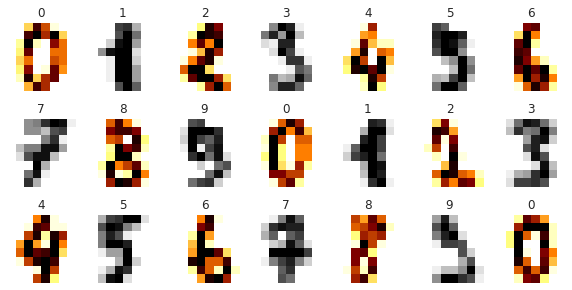

In [42]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [43]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [44]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true',cmap="YlGnBu")
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [45]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [46]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [47]:
lr_clf.fit(X_train, y_train)

In [48]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [49]:
model = CustomLogisticRegression()
model.fit(X_train, y_train)

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


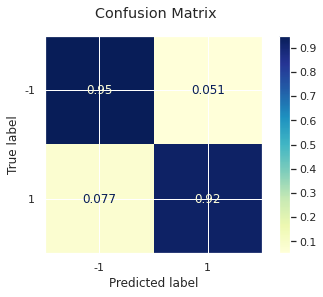

In [50]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9116214335421016, 0.9361111111111111)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

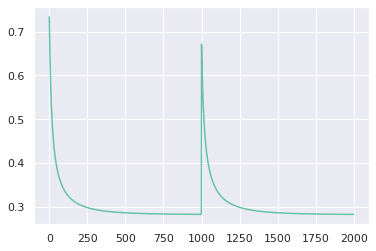

In [53]:
model.loss
plt.plot(model.loss)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


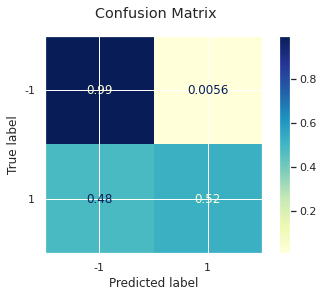

(0.7731384829505915, 0.7527777777777778)

In [19]:
model = CustomLogisticRegression(eta=0.01)
fit_evaluate(model, X_train, y_train, X_test, y_test)

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


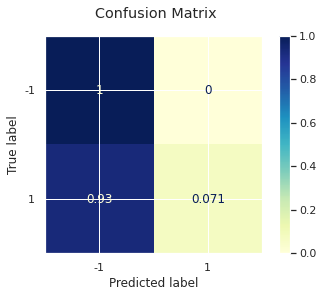

(0.5455810716771051, 0.5277777777777778)

In [20]:
model = CustomLogisticRegression(eta=0.1)
fit_evaluate(model, X_train, y_train, X_test, y_test)

Находим подходящее значение методом подбора (играемся с параметрами), при более малом learning rate получаем лучшие значения точности

**(0.5 points)** Try different regularization parameter values and compare the model quality.

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


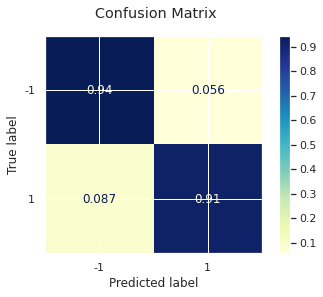

(0.9039665970772442, 0.9277777777777778)

In [21]:
model = CustomLogisticRegression(C=0.5)
fit_evaluate(model, X_train, y_train, X_test, y_test)

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


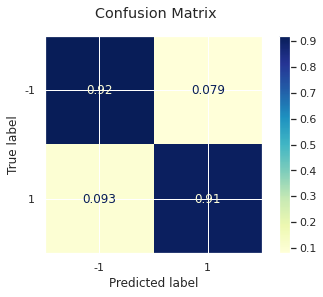

(0.8879610299234516, 0.9138888888888889)

In [22]:
model = CustomLogisticRegression(C=0.1)
fit_evaluate(model, X_train, y_train, X_test, y_test)

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


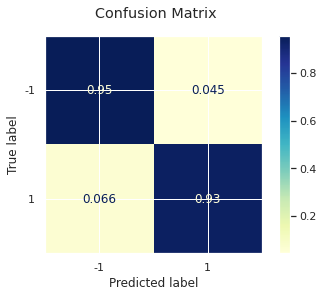

(0.9151009046624913, 0.9444444444444444)

In [23]:
model = CustomLogisticRegression(C=5)
fit_evaluate(model, X_train, y_train, X_test, y_test)

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


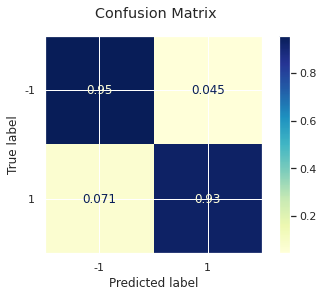

(0.9151009046624913, 0.9416666666666667)

In [24]:
model = CustomLogisticRegression(C=10)
fit_evaluate(model, X_train, y_train, X_test, y_test)

Регуляризация очень важна,  так как предостередает нашу модель от переобучения. Внашей модели с увеличением С модель дает лучший результат

**(0.5 points)** Compare zero initialization and random initialization. 

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


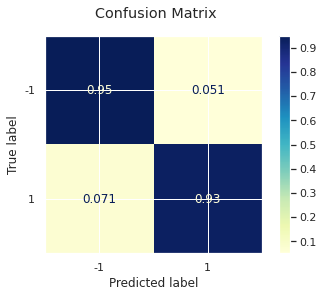

(0.9116214335421016, 0.9388888888888889)

In [25]:
model = CustomLogisticRegression(zero_init=True)
fit_evaluate(model, X_train, y_train, X_test, y_test)

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


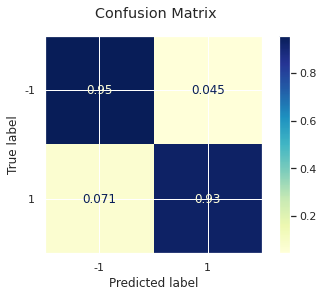

(0.9116214335421016, 0.9416666666666667)

In [26]:
model = CustomLogisticRegression(zero_init=False, random_state=0)
fit_evaluate(model, X_train, y_train, X_test, y_test)

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [27]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"

    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps


    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return (-2 * X @ Y.T + np.sum(Y ** 2,axis=1) + np.sum(X**2,axis=1)[:, np.newaxis])**.5

    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position
                corresponds to the weight of the i-th class.
        """
        list_sum = np.array([sum(weights[np.where(y == cl)]) for cl in self.classes_])

        return list_sum


    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)


    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """

        P = self.get_pairwise_distances(X, self.points)
        if hasattr(self, 'points'):

            nearest_points = P.argsort(axis=1)[:, :self.n_neighbors]
            distances = P[np.arange(P.shape[0])[:,None], nearest_points]
            labels = self.y[nearest_points]
            weights_ = np.ones(labels.shape)
            if self.weights == 'distance':
                weights_ = 1 / np.maximum(distances, self.eps)
                for i in range(len(P):
                    count_labels = self.get_class_weights(labels[i], weights_[i])
            weights_of_points = count_labels / np.expand_dims(count_labels.sum(axis=1), 1)
            return np.array(weights_of_points)

    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.array([np.argmax(y_pred) for y_pred in self.predict_proba(X)])

In [28]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [29]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [30]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

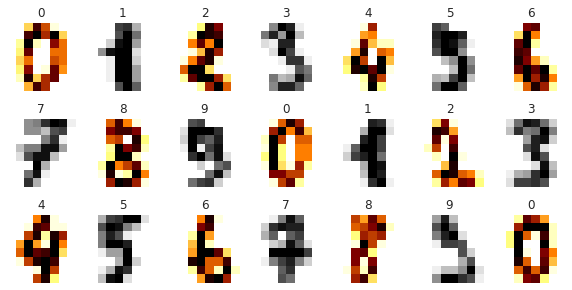

In [31]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [32]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [34]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

AssertionError: 

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


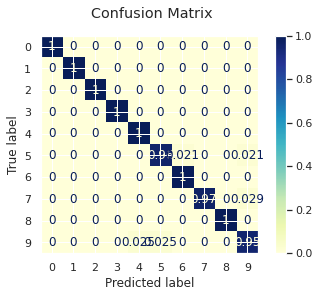

In [35]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [36]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
model = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
model.fit(X_train, y_train); probs = model.predict_proba(X_test)
probs.max(axis=1).min(), probs.max(axis=1).max()

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [23]:
PATH = "./data/"

In [24]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [25]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [26]:
data['Sex'].value_counts(dropna=False)

male      56114
female    43886
Name: Sex, dtype: int64

In [27]:
data['Survived'].value_counts(dropna=False)

0    57226
1    42774
Name: Survived, dtype: int64

In [28]:
male_fenale_stat = data.groupby('Sex')['Survived'].value_counts() \
    .reset_index(name="Number")\
    .pivot(index='Sex', columns='Survived', values='Number')\
    .rename(columns={0:'Died', 1:'Survived'})
male_fenale_stat

Survived,Died,Survived
Sex,,
female,12660,31226
male,44566,11548


< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

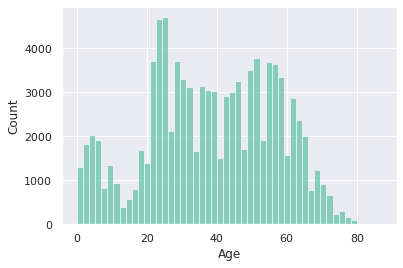

In [29]:
sns.histplot(data['Age'], bins = 50)

In [30]:
# average and  median ALL
data['Age'].mean(), data['Age'].median()

(38.35547214294577, 39.0)

In [31]:
# average and  median UNSurvived
data[data['Survived'] == 0]['Age'].mean(), data[data['Survived'] == 0]['Age'].median()

(36.70869488153374, 36.0)

In [32]:
# average and  median Survived
data[data['Survived'] == 1]['Age'].mean(), data[data['Survived'] == 1]['Age'].median()

(40.553799314307795, 43.0)

Средние и медианные значения практически совпадают, что говорит от отсутсвии значительный выбросов и симметричности данных. Стоит обратить анимание только на различия в возрасте  у выживших. Медианное значение выше, из чего можно сделать вывод что большее вышивших среди старшего поколения  >43 лет

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

%  survided by Class
Pclass=1 :  0.58
Pclass=2 :  0.53
Pclass=3 :  0.25


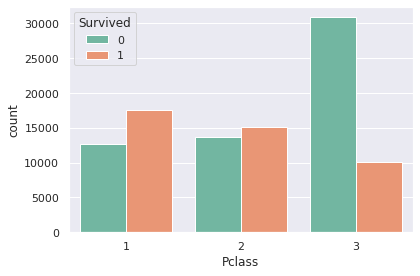

In [33]:

print('%  survided by Class')
print("Pclass=1 : ", (data.Survived[data.Pclass == 1].sum()/data[data.Pclass == 1].Survived.count()).round(2))
print("Pclass=2 : ", (data.Survived[data.Pclass == 2].sum()/data[data.Pclass == 2].Survived.count()).round(2))
print("Pclass=3 : ", (data.Survived[data.Pclass == 3].sum()/data[data.Pclass == 3].Survived.count()).round(2))
sns.countplot(x='Pclass', hue='Survived', data=data, );
plt.tight_layout()

             Survived
Embarked             
Cherbourg    0.751296
Queenstown   0.596976
Southampton  0.315294


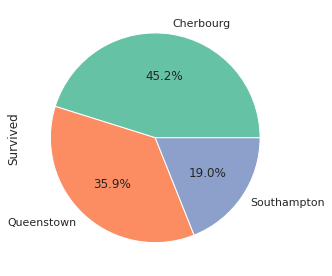

In [34]:
embarked_survived=data.pivot_table(values=['Survived'], index='Embarked')\
    .rename({'C': 'Cherbourg', 'S': 'Southampton', 'Q': 'Queenstown' })
print(embarked_survived)
embarked_survived['Survived'].plot.pie(autopct='%1.1f%%')
plt.tight_layout()

Наибольшее количество погибших в третьем классе как и большинсво пассажиров ехавших в этом классе. Но процентная составоябщая гласит, что если ты ехал в первом классе вероятность выжить - 58%
Что касается портов посадки пассажиров то шанс выжить был выше у тех кто селв в Cherbourg ( более 75%)


### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [35]:
data.isna().mean()

Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
Age         0.03292
SibSp       0.00000
Parch       0.00000
Ticket      0.04623
Fare        0.00134
Cabin       0.67866
Embarked    0.00250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Missing :
Age 3.3%
Ticket 4.6%
Fare 0.013%
Cabin 67.8%
Embarked 0.0025%


We can  fill missing values with mean, median or mode.
We also can fill the missing values before learn this value in specific group like Age=[0-5, 5-10...]

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [103]:
# read TRAIN
train = pd.read_csv('data/titanic/train.csv')
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
train['Cabin'] = train['Cabin'].fillna('U').apply(lambda x: x[0])
# read TEST
test = pd.read_csv('data/titanic/test.csv')
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Cabin'] = test['Cabin'].fillna('U').apply(lambda x: x[0])


In [104]:
def change_dataframe(df):
    sex = pd.get_dummies(df["Sex"],drop_first=True)
    embarked = pd.get_dummies(df["Embarked"]).rename(columns={'S':'Embarked_S','Q':'Embarked_Q','C':'Embarked_C'})
    pclass = pd.get_dummies(train["Pclass"]).rename(columns={1:'Class_1',2:'Class_2',3:'Class_3'})
    #df['Travel_Alone']=np.where((df["SibSp"]+df["Parch"])>0, 0, 1)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    cabin_one_hot = pd.get_dummies(df['Cabin'], prefix='Cabin')
    new_df = pd.concat([df, pclass,sex,embarked,cabin_one_hot],axis=1).rename(columns={'male':'Sex_male'})
    return new_df


In [105]:
train = change_dataframe(train)
test = change_dataframe(test)

In [106]:
features =  ['Age' ,'Class_2', 'Class_3', 'Fare', 'Embarked_S', 'Embarked_Q', 'Sex_male', 'FamilySize', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
            'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U']
target = ['Survived']
X_train = train[features]
y_train = train[target]
X_test = test[features]

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [107]:
lr = LogisticRegression(C=5, fit_intercept=True, intercept_scaling=1, max_iter=2000,
                        penalty='l2', random_state=42,
                        tol=0.01)

In [108]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=k_fold).mean()

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning

0.77139

In [111]:
lr.fit(X_train, y_train)

/home/user/PycharmProjects/DataSpell_venv/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=5, max_iter=2000, random_state=42, tol=0.01)

In [113]:
test = pd.read_csv('data/titanic/test.csv')
sub = pd.DataFrame()
sub['PassengerId'] = test.PassengerId
sub['Survived'] = lr.predict(X_test)
sub.to_csv('data/titanic/my_sub11.csv', index=False)

In [112]:
lr.score(X_train,y_train)

0.77145

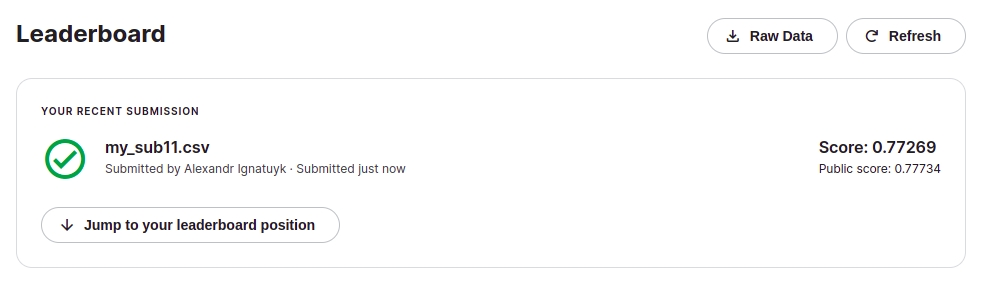

In [114]:
from IPython.display import Image
Image('1.jpg')